In [1]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTM
from GT import gmm_loss
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import AirQuality, MetrLA, PemsBay

DATASET_NAME = 'PemsBay'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 32
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0
bidirectional = True
mixture_dim = 20
debug = False
train_from_checkpoint = False
dataset = PemsBay()


## Dataset

In [4]:
dataset = dataset.dataframe()[-1000:]

In [5]:
# Dataset Split\
Train, Validation, Test = get_dataset('PemsBay', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

PemsBay DATA
________________________________________
Original Dataset: 	1000
Train Split: 		900 	(70%)
Validation Split: 	50 	(20%)
Test Split: 		50 	(10%)
________________________________________


## Model Train

In [6]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, debug
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 1, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

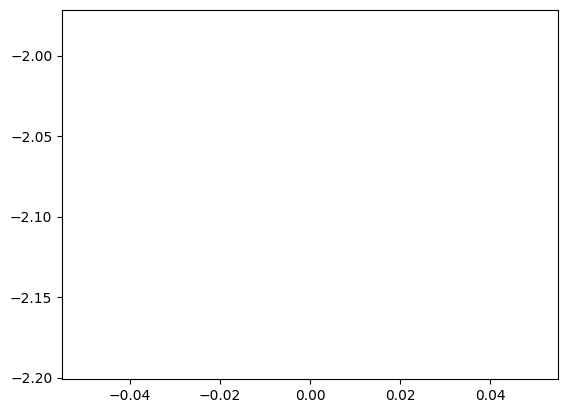

<Figure size 640x480 with 0 Axes>

In [7]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

In [8]:
train_label.shape

torch.Size([899, 1, 325])

## Predict on Train

In [9]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=0, steps=899, mode='mean')

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:200, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='PemsBay')
data_predicted = denormalize(data_predicted, name='PemsBay')
# for i in range(10):
#     first_elements_arr1 = [subarr[i] for subarr in data_true]
#     first_elements_arr2 = [subarr[i] for subarr in data_predicted]
#     # Plotting
#     plt.plot(first_elements_arr1, label='True')
#     plt.plot(first_elements_arr2, label='Predicted')
#     plt.xlabel('Index')
#     plt.ylabel('Values')
#     plt.title(f'Line Plot of Train Feature {i}')
#     plt.legend()
#     plt.show()
#     plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
#     plt.clf()

100%|██████████| 899/899 [00:09<00:00, 97.11it/s] 


## Generate on Train

In [10]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
# output = model.generate_step(train_data, start=0, steps=1000, mode='mean')

# # data_true = denormalize(train_label[0:200, :, :].numpy())
# data_true = train_label[25:200, :, :].numpy()
# data_predicted = output.reshape(output.shape[0], output.shape[-1])
# data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

# data_true = denormalize(data_true, name='PemsBay')
# data_predicted = denormalize(data_predicted, name='PemsBay')

# data_predicted
# for i in range(10):
#     first_elements_arr1 = [subarr[i] for subarr in data_true]
#     first_elements_arr2 = [subarr[i] for subarr in data_predicted]
#     # Plotting
#     plt.plot(first_elements_arr1, label='True')
#     plt.plot(first_elements_arr2, label='Generated')
#     plt.xlabel('Index')
#     plt.ylabel('Values')
#     plt.title(f'Line Plot of Train Feature {i}')
#     plt.legend()
#     plt.show()
#     plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
#     plt.clf()

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(data_predicted)
str = [400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,400073,400084,400085,400088,400096,400097,400100,400104,400109,400122,400147,400148,400149,400158,400160,400168,400172,400174,400178,400185,400201,400206,400209,400213,400221,400222,400227,400236,400238,400240,400246,400253,400257,400258,400268,400274,400278,400280,400292,400296,400298,400330,400336,400343,400353,400372,400394,400400,400414,400418,400429,400435,400436,400440,400449,400457,400461,400464,400479,400485,400499,400507,400508,400514,400519,400528,400545,400560,400563,400567,400581,400582,400586,400637,400643,400648,400649,400654,400664,400665,400668,400673,400677,400687,400688,400690,400700,400709,400713,400714,400715,400717,400723,400743,400750,400760,400772,400790,400792,400794,400799,400804,400822,400823,400828,400832,400837,400842,400863,400869,400873,400895,400904,400907,400911,400916,400922,400934,400951,400952,400953,400964,400965,400970,400971,400973,400995,400996,401014,401129,401154,401163,401167,401210,401224,401327,401351,401388,401391,401400,401403,401440,401457,401464,401489,401495,401507,401534,401541,401555,401560,401567,401597,401606,401611,401655,401808,401809,401810,401811,401816,401817,401845,401846,401890,401891,401906,401908,401926,401936,401937,401942,401943,401948,401957,401958,401994,401996,401997,401998,402056,402057,402058,402059,402060,402061,402067,402117,402118,402119,402120,402121,402281,402282,402283,402284,402285,402286,402287,402288,402289,402359,402360,402361,402362,402363,402364,402365,402366,402367,402368,402369,402370,402371,402372,402373,403225,403265,403329,403401,403402,403404,403406,403409,403412,403414,403419,404370,404434,404435,404444,404451,404452,404453,404461,404462,404521,404522,404553,404554,404585,404586,404640,404753,404759,405613,405619,405701,407150,407151,407152,407153,407155,407157,407161,407165,407172,407173,407174,407176,407177,407179,407180,407181,407184,407185,407186,407187,407190,407191,407194,407200,407202,407204,407206,407207,407321,407323,407325,407328,407331,407332,407335,407336,407337,407339,407341,407342,407344,407348,407352,407359,407360,407361,407364,407367,407370,407372,407373,407374,407710,407711,408907,408911,409524,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694]

In [13]:
df.columns = str

In [14]:
df.to_csv('TeachForcingPemsBayGTM.csv', index=False)

In [15]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

7003.9736
0.006826632656157017
17991467008.0
